In [2]:
import numpy as np
import torch

# load the data
X = np.load('data/x.npy')
y = np.load('data/y.npy')

# reshape y to be [n_samples, 1]
y = y.reshape(y.shape[0], 1)


# split the data into train and test
X_train = X[:int(len(X) * 0.8)]
y_train = y[:int(len(y) * 0.8)]
X_test = X[int(len(X) * 0.8):]
y_test = y[int(len(y) * 0.8):]

# convert to torch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()


X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [3]:
import torch.functional as F
import torch
import torch.nn as nn

relu = F.F.relu


# define the neural network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # autoencoder start with input size 
        self.fc1 = nn.Linear(12*8*8, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.5)
        # embedding layer
        self.fc4 = nn.Linear(256, 128)
        self.dropout4 = nn.Dropout(0.5)
        # decoder
        self.fc5 = nn.Linear(128,256)
        self.dropout5 = nn.Dropout(0.5)
        self.fc6 = nn.Linear(256, 512)
        self.dropout6 = nn.Dropout(0.5)
        self.fc7 = nn.Linear(512, 1024)
        self.dropout7 = nn.Dropout(0.5)
        self.fc8 = nn.Linear(1024, 12*8*8)



    def forward(self, x):
        # reshape
        x = x.view(-1, 12*8*8)
        # pass
        x = relu(self.fc1(x))
        x = self.dropout1(x)
        x = relu(self.fc2(x))
        x = self.dropout2(x)
        x = relu(self.fc3(x))
        x = self.dropout3(x)
        x = relu(self.fc4(x))
        x = self.dropout4(x)
        x = relu(self.fc5(x))
        x = self.dropout5(x)
        x = relu(self.fc6(x))
        x = self.dropout6(x)
        x = relu(self.fc7(x))
        x = self.dropout7(x)
        x = self.fc8(x)
        # reshape
        return x.view(-1, 12, 8, 8)
    
    # def predict(self, x):
    #     # reshape
    #     x = x.view(-1, 12*8*8)

    #     # forward pass
    #     x = relu(self.fc1(x))
    #     x = relu(self.fc2(x))
    #     x = relu(self.fc3(x))
    #     x = relu(self.fc4(x))
    #     x = relu(self.fc5(x))
    #     x = relu(self.fc6(x))
    #     x = relu(self.fc7(x))
    #     x = self.fc7(x)
    #     return x
    
    def embed(self, x):
        # reshape
        x = x.view(-1, 12*8*8)

        # forward pass
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = relu(self.fc3(x))
        x = relu(self.fc4(x))
        return x

In [4]:
# define the loss function
criterion = torch.nn.L1Loss()

MODEL_PATH = 'model_material.pth'

# load the model
net = Net()
net.load_state_dict(torch.load(MODEL_PATH))

# test the model
with torch.no_grad():
    outputs = net.predict(X_test)
    loss = criterion(outputs, y_test)
    print('test loss: {}'.format(abs(loss.item())))

AttributeError: 'Net' object has no attribute 'predict'

In [5]:
# generate 200 embeddings

print(len(X_test))

with torch.no_grad():
    outputs = net.embed(X_test)
    print(outputs.shape)


# fit the embeddings to a 2d plane uing t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=100, n_iter=2000, verbose=1, learning_rate=1)
outputs = tsne.fit_transform(outputs)

# save the embeddings as a js file with syntax as follows:
# const embeddings = [{x: something, y: something, score: something}, ...]

with open('embeddings.ts', 'w') as f:
    f.write('export const embeddings = [')
    for i in range(len(outputs)):
        f.write('{{x: {}, y: {}, score: {}, i: {}}},'.format(outputs[i][0], outputs[i][1], y_test[i][0], i))
    f.write(']')


406
torch.Size([406, 128])
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 406 samples in 0.001s...
[t-SNE] Computed neighbors for 406 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 406 / 406
[t-SNE] Mean sigma: 0.279253
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.111794
[t-SNE] KL divergence after 1400 iterations: 0.037771


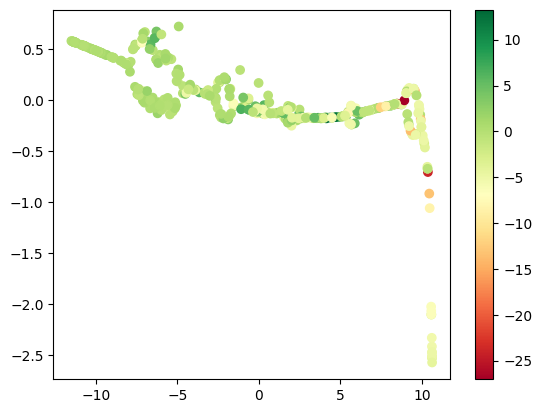

In [6]:
# preview the embeddings in a scatter plot
import matplotlib.pyplot as plt

plt.scatter(outputs[:, 0], outputs[:, 1], c=y_test[:, 0], cmap='RdYlGn')
plt.colorbar()


